# Hearth diseases AI

## Developing an AI to spot an hearth disease from patient's medical informations.

### Imports 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Open the medical informations in a dataFrame

In [2]:
df = pd.read_csv('heart_2020_cleaned.csv')

### Clean the data
#### Transform the categorical 2 choises data (yes/no) into a 0/1 

#### For the categotical with more possibilty we create new columns and add prefixes to them

In [3]:
for col in ['Smoking', 'HeartDisease', 'PhysicalActivity', 'KidneyDisease', 'Asthma', 'SkinCancer', 'DiffWalking', 'AlcoholDrinking', 'Stroke', 'Sex']:
    if df[col].dtype == 'O':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

df = pd.get_dummies(df, columns=['GenHealth', 'Diabetic', 'Race'], prefix = ['GenHealth', 'Diabetic', 'Race'])

#### Transform the AgeCategory intervals into average

In [4]:
average_AgeCategory = {
    '80 or older':80,'75-79':77,'70-74':72,'65-69':67,'60-64':62,
    '55-59':57,'50-54':52,'45-49':47,'40-44':42,'35-39':37,
    '30-34':32,'25-29':27,'18-24':21
    }

df['AgeCategory'] = df['AgeCategory'].apply(lambda x: average_AgeCategory[x])
df['AgeCategory'] = df['AgeCategory'].astype('float')

### Choose the Features

#### To find the "useful/impactful" features we decided to make a DescisionTree

In [5]:
x_train = np.array(df[['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'PhysicalActivity', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Race_American Indian/Alaskan Native', 'Race_Asian',
       'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White',
       'Diabetic_No', 'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'GenHealth_Excellent',
       'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor',
       'GenHealth_Very good']])
y_train = np.array(df['HeartDisease'])

#### Create a classifier tree

In [6]:
tree = DecisionTreeClassifier(random_state=0) 
tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

####  Show the features importance in the DataFrame

[0.36190476 0.02049584 0.01073049 0.03074504 0.07151473 0.06402016
 0.02318578 0.0161354  0.09477983 0.03145909 0.104      0.02121535
 0.01124296 0.02667243 0.00418815 0.00240349 0.00805828 0.00726467
 0.00573908 0.01175945 0.00705128 0.0044191  0.0085835  0.00099088
 0.0026987  0.01682725 0.00984338 0.01780368 0.00426724]


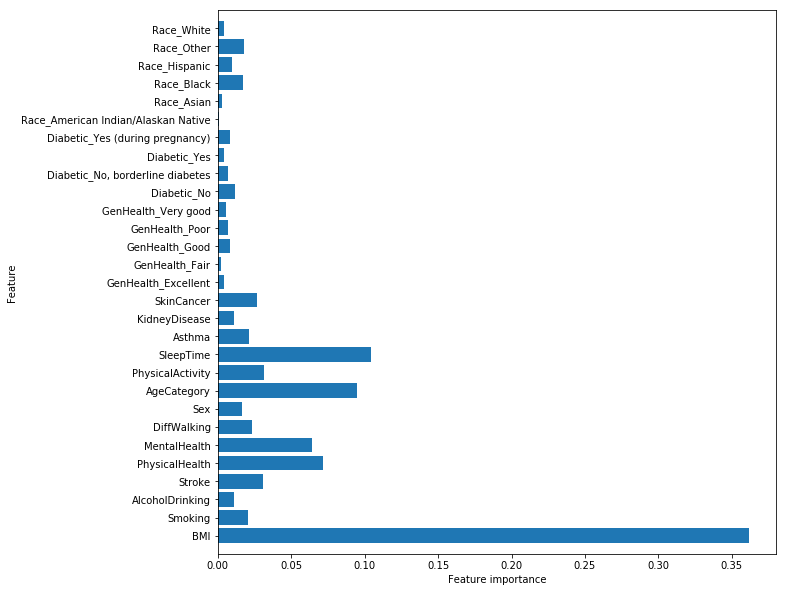

In [7]:
dataset = df.drop("HeartDisease", 1)
n_features = dataset.shape[1]
plt.figure(figsize=(10,10))
plt.barh(np.arange(n_features), tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), dataset.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature") 
plt.ylim(-1, n_features)
            
print(tree.feature_importances_)

### Balance the DataSet

#### We split the DataFrame. 80 % for the training and 20% for validation

In [8]:
train_df = df[:int(len(df)*0.8)]
val_df = df[int(len(df)*0.8):]

####  We balanced it by oversampling the data, to have the same amount of positive/negative HeartDisease

In [9]:
not_sick = val_df[val_df['HeartDisease'] == 0]
sick = val_df[val_df['HeartDisease'] == 1]

sick = sick.sample(len(not_sick),replace=True)
val_df = pd.concat([not_sick, sick], axis=0)
print('Data in Test:')
print(val_df['HeartDisease'].value_counts())

Data in Test:
1    58571
0    58571
Name: HeartDisease, dtype: int64


In [10]:
not_sick = train_df[train_df['HeartDisease'] == 0]
sick = train_df[train_df['HeartDisease'] == 1]

sick = sick.sample(len(not_sick),replace=True)
train_df = pd.concat([not_sick, sick], axis=0)
print('Data in Train:')
print(train_df['HeartDisease'].value_counts())

Data in Train:
1    233851
0    233851
Name: HeartDisease, dtype: int64


### Create the model

####  Select our main features to create the AI

In [11]:
x_train = np.array(train_df[['BMI', 'Stroke',
       'PhysicalHealth', 'MentalHealth','SleepTime', 'AgeCategory', 'Stroke', 'PhysicalActivity']])
y_train = np.array(train_df['HeartDisease'])

x_val = np.array(val_df[['BMI', 'Stroke',
       'PhysicalHealth', 'MentalHealth','SleepTime', 'AgeCategory', 'Stroke', 'PhysicalActivity']])
y_val = np.array(val_df['HeartDisease'])

#### Create our RandomForestClassifier model

In [12]:
rf = RandomForestClassifier().fit(x_train, y_train)

y_pred = rf.predict(x_val)

#### Show the result of the AI

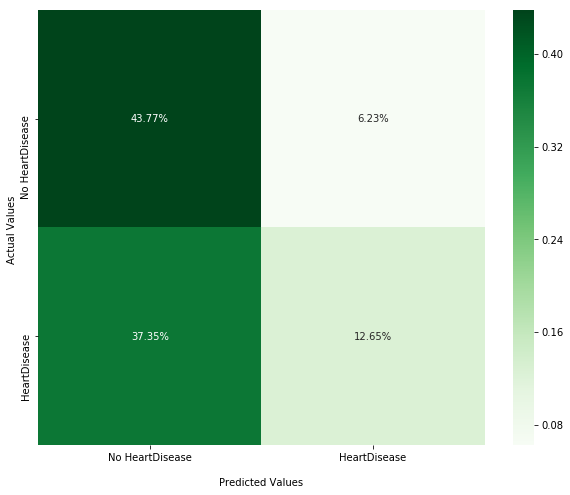

In [13]:
matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10,8))

diag = sns.heatmap(matrix/np.sum(matrix),fmt='.2%', annot=True, cmap='Greens')

diag.set_xlabel('\nPredicted Values')
diag.set_ylabel('Actual Values ');

diag.xaxis.set_ticklabels(['No HeartDisease','HeartDisease'])
diag.yaxis.set_ticklabels(['No HeartDisease','HeartDisease'])

plt.show()